# Housing prices from Kaggle

### Case Type
* Target is numeric and continuous.
* 80 features (both numeric and categorical)
* Train data has 1460 instances.
* Test data download from Kaggle is not used (not target).

### Goal
To predict housing prices based on its properties.


### Sources
* https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
* https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/
* https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d
* https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
* https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv
* https://datascience.stackexchange.com/questions/17282/xgbregressor-vs-xgboost-train-huge-speed-difference
* https://www.datacamp.com/community/tutorials/xgboost-in-python
* https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
* https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

### Description
For a description of the data, please see ./data/data_description.txt

### Imports

In [244]:
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics

import xgboost as xgb
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

# Data Preparation

### Load Data

In [245]:
df_raw = pd.read_csv('./data/train.csv', header=0)
print('Dataframe shape is: ', df_raw.shape)
print('Columns are: ', df_raw.columns)
df_raw.head()

Dataframe shape is:  (1460, 81)
Columns are:  Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Subselect the relevant data

In [246]:
cols = ['MSZoning', 'LotArea', 'Street',
        'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'TotalBsmtSF', 'Heating',
        'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
        'GarageArea', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'SalePrice']

df = df_raw[cols]

#To try: 'MSSubClass', 'LotFrontage'
#'Condition1', 'Condition2' - same encoding
#OpenPorchSF + EnclosedPorch

In [247]:
#Inspect data for NaN.
print('Dataframe shape: ', df.shape)
print(df.isna().sum())

Dataframe shape:  (1460, 53)
MSZoning          0
LotArea           0
Street            0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
MasVnrArea        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
BsmtFinSF1        0
BsmtFinType2     38
TotalBsmtSF       0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
1stFlrSF          0
2ndFlrSF          0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
KitchenQual       0
TotRmsAbvGrd      0
Functional        0
Fireplaces        0
FireplaceQu     690
GarageType       81
GarageArea        0
GarageCond       81
PavedDrive        0
WoodDeckSF 

### Inspect NaN data

In [248]:
#Fireplace Quality. Does it relate to places with no fireplace?
df[['FireplaceQu']] = df[['FireplaceQu']].fillna('No_fireplace')

/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/pandas/core/frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<Figure size 720x720 with 0 Axes>

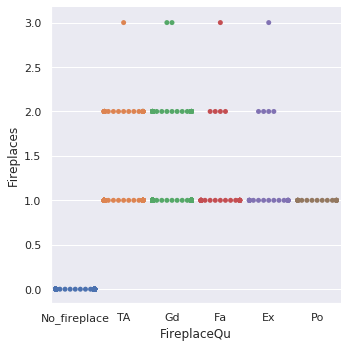

In [249]:
plt.figure(figsize=(10,10))
sns.catplot(x='FireplaceQu', y='Fireplaces', kind="swarm", data=df)
#Indeed, the fireplace quality in the 'FireplaceQu' column is NaN if the house has no fireplace.

<Figure size 720x720 with 0 Axes>

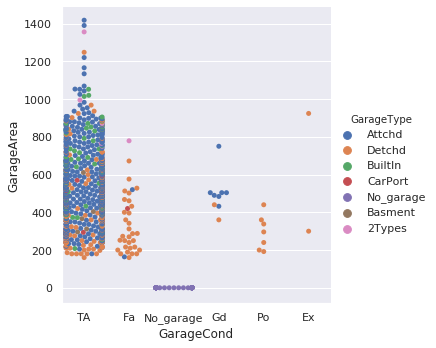

In [250]:
#How does the NaN in GarageCond relate to GarageType and GarageArea
plt.figure(figsize=(10,10))
df[['GarageCond', 'GarageType']] = df[['GarageCond', 'GarageType']].fillna('No_garage')
sns.catplot(x='GarageCond', y='GarageArea', hue='GarageType', kind="swarm", data=df)
#Indeed, NaN in GarageCond and GarageType correspond to a GarageArea of zero.
#We can also see that some GarareType labels are under-represented.

In [251]:
#Basements.
cols = ['BsmtFinType1', 'BsmtCond', 'BsmtQual', 'BsmtFinType2']
df[cols] = df[cols].fillna('No_basement')
#Indeed, the fireplace quality in the 'FireplaceQu' column is NaN if the house has no fireplace.')

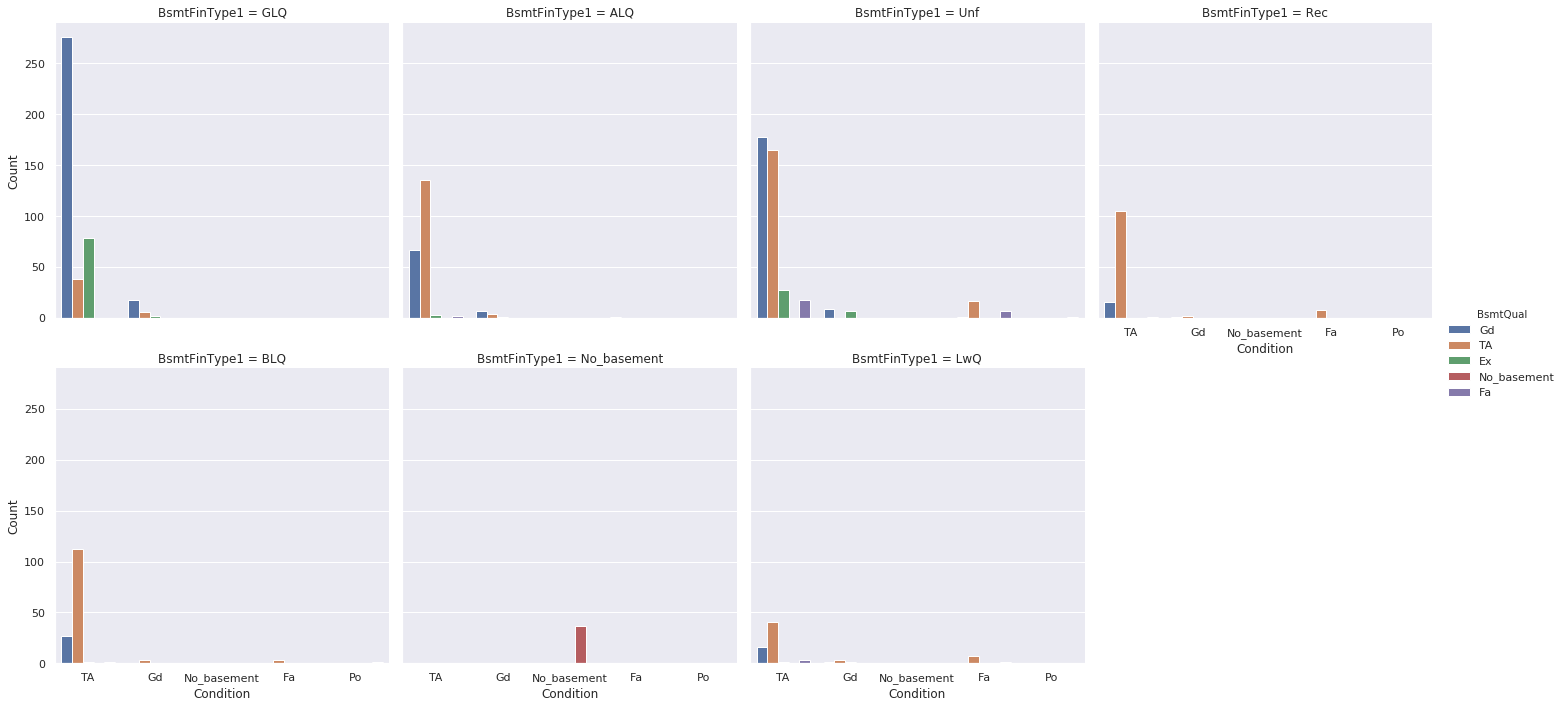

In [156]:
sns.catplot(
  kind='count', data=df, col='BsmtFinType1',
  col_wrap=4, x='BsmtCond', hue='BsmtQual').set_axis_labels("Condition", "Count")

<Figure size 720x720 with 0 Axes>

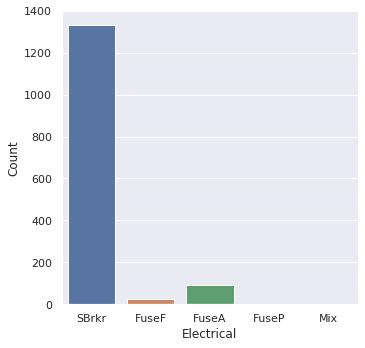

In [157]:
#Electrical
plt.figure(figsize=(10,10))
sns.catplot(kind='count', data=df, x='Electrical').set_axis_labels("Electrical", "Count")
#This does not seem very informative. Drop this feature.

### Inspect the distribution of each variable

In [252]:
#Categorical:

categorical = ['MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
               'ExterQual', 'ExterCond',  'Foundation', 'BsmtQual', 'BsmtCond',
               'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional',
               'FireplaceQu', 'GarageType', 'GarageCond', 'PavedDrive', 'Electrical',
               'OverallCond', 'YearRemodAdd', 'YearBuilt']

#Numeric
numeric = ['LotArea', 'OverallQual', 'MasVnrArea', 'BsmtFinSF1',
           'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
           'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
           'Fireplaces', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

In [253]:
print('Number of categorical features: ', len(categorical))
print('Number of numeric features: ', len(numeric))

Number of categorical features:  31
Number of numeric features:  22


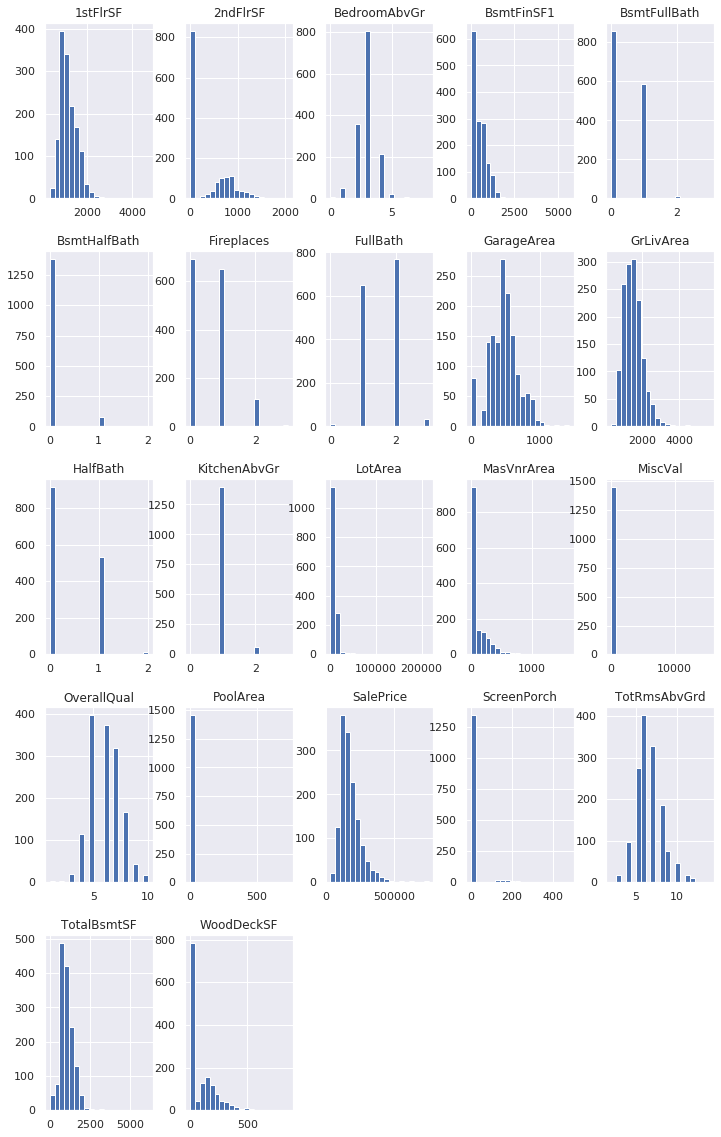

In [160]:
#Show the histogram of all numeric variables. Inspect for outliers and meaningless features.
sns.set(font_scale=1.)
hist = df[numeric].hist(bins=20, figsize=(12,20), layout=(5,5))

In [254]:
#Remove the numeric variables that are not relevant.
try:
    numeric.remove('ScreenPorch')
    numeric.remove('MiscVal')
    numeric.remove('PoolArea')
except:
    pass

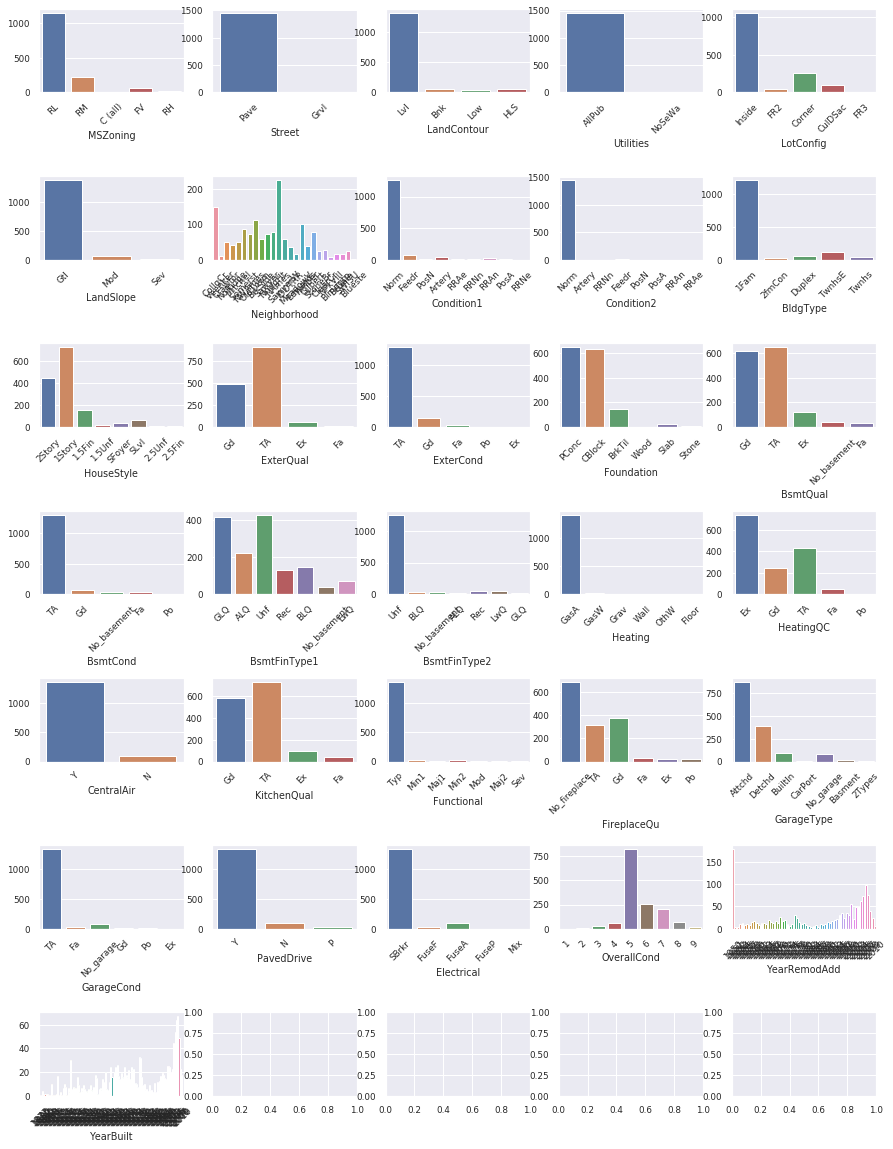

In [162]:
#Show a count of all categorical variables. Inspect for outliers and meaningless features.
#https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d
sns.set(font_scale=.8)
fig, ax = plt.subplots(7, 5, figsize=(15, 20))
plt.subplots_adjust(hspace=1.)
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    subplot.set_ylabel('')
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

In [255]:
#Remove the categorical variables that are not relevant.
try:
    categorical.remove('Street')
    categorical.remove('Utilities')
    categorical.remove('LandSlope')
    categorical.remove('Condition2')
    categorical.remove('Heating')
    categorical.remove('BsmtFinType2')
    categorical.remove('Functional')
    categorical.remove('Electrical')
except:
    pass

In [256]:
#Update dataframe to include only the numeric and categorical features to keep.
df = df[numeric + categorical]

### Remove under-represented attributes

In [257]:
#Among the categorical features, if an attribute is present in less than 1% of the instances,
#then replace that attribute with the most common attribute of that feature.

#Do note include 'ranked' features, such as OverallCond.
unranked_cat = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
                'Condition1', 'BldgType', 'HouseStyle', 
                'ExterCond', 'Foundation', 'CentralAir', 'GarageType', 'PavedDrive']


ranked_cat = ['YearRemodAdd', 'YearBuilt', 'OverallCond',  'GarageCond', 'KitchenQual',
              'ExterQual', 'BsmtCond', 'BsmtQual', 'HeatingQC', 'FireplaceQu', 'BsmtFinType1']


In [258]:
tol = 0.01
n_instances = df.shape[0]
n_tol = int(tol * n_instances)

for feature in unranked_cat:
    mode = df[feature].mode()
    for attribute, count in df[feature].value_counts().iteritems(): 
        if count < n_tol:
            df[feature][df[feature] == attribute] = mode 

/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/pandas/core/generic.py:9116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [259]:
#Check if any categorical feature only has one attribute. If so, remove it.
for feature in unranked_cat:
    if df[feature].nunique() <= 1:
        print('Dropping feature %s, which has %d unique attributes' %(feature, df[feature].nunique()))
        df.drop([feature], inplace=True)

### Search for Outliers

(8.0, 0.0)

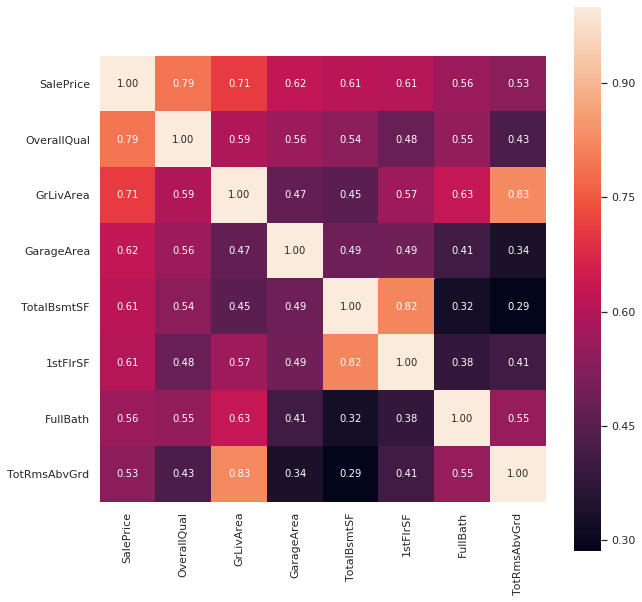

In [260]:
#Find the top N features that show the strongest positive or negative correlation with SalePrice
#Source: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

#correlation matrix
corrmat = df.corr()

k = 8 #number of variables for heatmap
fig, ax = plt.subplots(figsize=(10, 10))
cols = np.absolute(corrmat).nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values, ax=ax)

#Fix first and last rows. (Bug in recent matplotlib)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


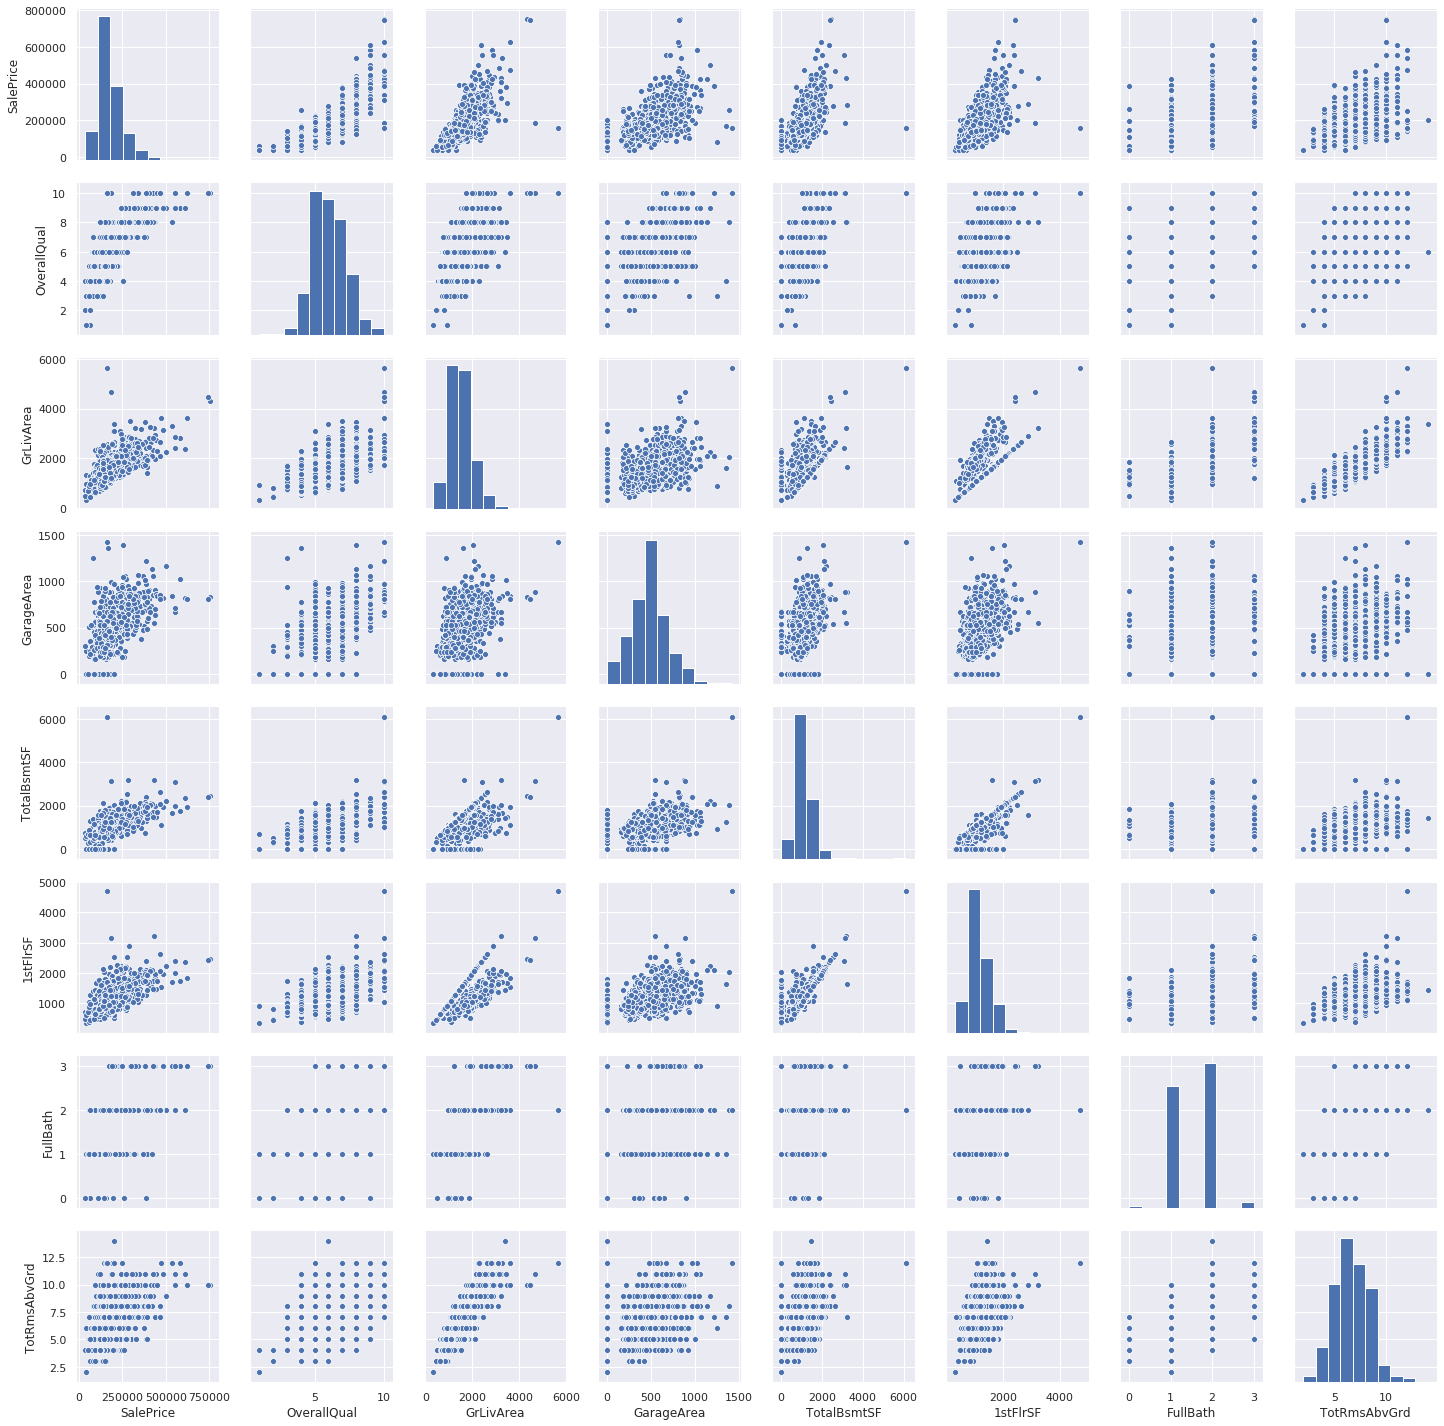

In [261]:
#Make a Cornerplot of the top 10 correlated varibles and visually inspect for outliers.
sns.set(font_scale=1.)
g = sns.pairplot(df[cols])

In [262]:
#Remove outliers.
df = df.drop(df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 400000)].index)
df = df.drop(df[(df['TotalBsmtSF'] > 5000)].index)
df = df.drop(df[(df['1stFlrSF'] > 4000)].index)

### Data pre-processing

In [263]:
#Basic stats
print(df[categorical].nunique())

MSZoning          4
LandContour       4
LotConfig         4
Neighborhood     22
Condition1        5
BldgType          5
HouseStyle        6
ExterQual         4
ExterCond         3
Foundation        4
BsmtQual          5
BsmtCond          5
BsmtFinType1      7
HeatingQC         5
CentralAir        2
KitchenQual       4
FireplaceQu       6
GarageType        5
GarageCond        6
PavedDrive        3
OverallCond       9
YearRemodAdd     61
YearBuilt       112
dtype: int64


### Feature engineering

In [264]:
#Create feature with total area
# Adding total sqfootage feature 
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

### Deal with NaN

In [265]:
def treat_nan(_df):
    #Deal with NaN values.
    _df[['FireplaceQu']] = _df[['FireplaceQu']].fillna('No_fireplace')
    _df[['GarageType']] = _df[['GarageType']].fillna('No_garage')
    _df[['BsmtQual', 'BsmtFinType1']] = _df[['BsmtQual', 'BsmtFinType1']].fillna('No_garage')    
    return _df


### Encode categorical features

In [266]:
# encode string input values as integers
def encode_ordered_categorical(_df):
    
    #For catgorical features that are ordered or are binomial, use
    #For the other categorical features, we will use pandas get_dummies,
    #which is equivalent to one hot encoding.
    
    encode_features = ['YearRemodAdd', 'YearBuilt', 'OverallCond',  'GarageCond',
                       'KitchenQual', 'CentralAir', 'ExterQual', 'BsmtCond', 'BsmtQual',
                       'HeatingQC', 'FireplaceQu', 'BsmtFinType1']
   
    for feature in encode_features:
        lbl = LabelEncoder() 
        lbl.fit(list(_df[feature].values)) 
        _df[feature] = lbl.transform(list(_df[feature].values))
    return _df

### Transform features whose distribution is highly skewed

In [267]:
#Apply a log (1 + x) in the highly skewed features
def apply_log1p(_df):

    numeric_features = _df.dtypes[_df.dtypes != 'object'].index

    # Check the skew of all numerical features
    skewed_features = _df[numeric_features].apply(
      lambda x: skew(x.dropna())).sort_values(ascending=False)

    skewness = pd.DataFrame({'Skew': skewed_features})
    skewness = skewness[abs(skewness.values) > .75]

    skewed_features = skewness.index
    lam = 0.15
    for feature in skewed_features:
        _df[feature] = np.log1p(_df[feature])
    return _df

### Encode non-ranked categorical features

In [268]:
def apply_dummies(_df):
    _df = pd.get_dummies(_df)
    return _df

### Split the data between train and test sets

In [269]:
#Separate the data into target (y) and features (X)
def split_sample(_df):
    y = _df['SalePrice'].values
    _df.drop(['SalePrice'], axis=1, inplace=True)
    X = _df.values
    Train_X, Test_X, Train_y, Test_y = train_test_split(X, y, test_size=0.2, random_state=0)
    return Train_X, Test_X, Train_y, Test_y

### Data Imputation

In [270]:
def num_imputation(X_train, X_test):
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_median.fit(X_train)
    X_train = imp_median.transform(X_train)
    X_test = imp_median.transform(X_test)
    return X_train, X_test

### Standardize numeric features

In [271]:
def standardize_numeric(_Train_X, _Test_X):
    scaler = StandardScaler()
    scaler.fit(_Train_X)
    Train_X_scaled = scaler.transform(_Train_X)
    Test_X_scaled = scaler.transform(_Test_X)
    return Train_X_scaled, Test_X_scaled

### Data pre-processing Pipeline

In [272]:
def preproc_data(_df):
    _df = treat_nan(_df)    
    _df = encode_ordered_categorical(_df)
    _df = apply_log1p(_df)
    _df = apply_dummies(_df)
    
    Train_X, Test_X, Train_y, Test_y = split_sample(_df)
    Train_X, Test_X = num_imputation(Train_X, Test_X)     
    #Train_X, Test_X = standardize_numeric(Train_X, Test_X)
    return Train_X, Test_X, Train_y, Test_y

In [273]:
Train_X, Test_X, Train_y, Test_y = preproc_data(df)

In [274]:
print('Shape of train dataset: ', Train_X.shape)
print('Shape of train target: ', Train_y.shape)
print('Shape of test dataset: ', Test_X.shape)
print('Shape of test target: ', Test_y.shape)

Shape of train dataset:  (1166, 96)
Shape of train target:  (1166,)
Shape of test dataset:  (292, 96)
Shape of test target:  (292,)


# Model Testing

### Verbose function

In [275]:
def print_metrics(_pred_y, _Test_y):
    
    lin_pred_y = np.exp(_pred_y) - 1
    lin_Test_y = np.exp(_Test_y) - 1
    
    mean_Test_y = np.mean(lin_Test_y)
    
    mse = metrics.mean_squared_error(_pred_y, _Test_y)
    lin_mse = metrics.mean_squared_error(lin_pred_y, lin_Test_y)
    lin_mae = metrics.mean_absolute_error(lin_pred_y, lin_Test_y)    
    
    print('Root Mean squared error %.4f' %np.sqrt(mse))
    print('Linear Mean square error: %d' %lin_mse)
    print('Linear Mean absolute error: %d' %lin_mae)
    print('Percent error from mean values: %.2f%%' %(lin_mae/mean_Test_y*100.))

### Use LinearRegression as a benchmark

In [276]:
lr = LinearRegression()
lr.fit(Train_X, Train_y)
pred_y = lr.predict(Test_X)

print_metrics(pred_y, Test_y)

Root Mean squared error 0.1103
Linear Mean square error: 469123413
Linear Mean absolute error: 14705
Percent error from mean values: 7.93%


### Ridge Regression

In [277]:
rr = RidgeCV(alphas=np.logspace(-3,2,100), cv=5)
rr.fit(Train_X, Train_y)
pred_y = rr.predict(Test_X)
print_metrics(pred_y, Test_y)

Root Mean squared error 0.1104
Linear Mean square error: 460976264
Linear Mean absolute error: 14627
Percent error from mean values: 7.89%


### Lasso Regression

In [307]:
lar = LassoCV(alphas=np.logspace(-5,-1,100), cv=5, random_state=21)
lar.fit(Train_X, Train_y)
pred_y = lar.predict(Test_X)
print_metrics(pred_y, Test_y)

Root Mean squared error 0.1094
Linear Mean square error: 464859461
Linear Mean absolute error: 14560
Percent error from mean values: 7.86%


In [308]:
lar.alpha_

8.497534359086438e-05

### Random Forest

In [213]:
#Define grid for parameter search.
random_grid = {'n_estimators': [int(x) for x in np.logspace(2.3,4,15)],
               'max_features': np.arange(10,21,2),
               'max_depth': np.arange(15,31,5),
               'min_samples_split': np.arange(5,16,5),
               'min_samples_leaf': np.arange(1,11,5)}

In [214]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=0,
                               n_jobs=-1)

rf_random.fit(Train_X, Train_y)
pred_y = rf_random.predict(Test_X)
print_metrics(pred_y, Test_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.8s
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.2min finished


Root Mean squared error 0.1199
Linear Mean square error: 594312008
Linear Mean absolute error: 16231
Percent error from mean values: 8.76%


In [218]:
rf_random.best_params_

{'n_estimators': 4322,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 20,
 'max_depth': 20}

### XGBoost - Complete grid search
Reliable grid search, but takes too long.

In [279]:
xgbr = xgb.XGBRegressor()

parameters = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(Train_X, Train_y)
pred_y = xgb_grid.predict(Test_X)
print_metrics(pred_y, Test_y)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   57.2s finished


Root Mean squared error 0.1111
Linear Mean square error: 428610686
Linear Mean absolute error: 14179
Percent error from mean values: 7.65%


In [280]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

### Initialize Regression Models

In [281]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Train_X)
    rmse= np.sqrt(-cross_val_score(model, Train_X, Train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [311]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0001, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

### Evaluate Base Models

In [312]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1192 (0.0071)



In [284]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1208 (0.0098)



In [285]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1505 (0.0215)



In [286]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1242 (0.0148)



In [287]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1238 (0.0143)



### Create Class to Average Model Predictions
This class needs a fit and predict methods.

In [288]:
#https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [289]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso, model_xgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1160 (0.0120)

